<a href="https://colab.research.google.com/github/kzihon/Tensorflow-deep-learning/blob/main/04_Transfer_Learning_with_TensorFlow_Part_1_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#04. Transfer Learning with TensorFlow Part 1: Feature Extraction

In [1]:
!nvidia-smi

Fri Aug 18 02:13:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Transfer leanring with TensorFlow Hub: Getting great results with 10% of the data

####Transfer learning often allows you to get great results with less data.

In [2]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref= zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-08-18 02:13:01--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 64.233.170.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  19.3MB/s    in 9.7s    

2023-08-18 02:13:11 (16.6 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories  and {len(filenames)} images in '{dirpath}'")

There are 2 directories  and 0 images in '10_food_classes_10_percent'
There are 10 directories  and 0 images in '10_food_classes_10_percent/train'
There are 0 directories  and 75 images in '10_food_classes_10_percent/train/ramen'
There are 0 directories  and 75 images in '10_food_classes_10_percent/train/chicken_curry'
There are 0 directories  and 75 images in '10_food_classes_10_percent/train/pizza'
There are 0 directories  and 75 images in '10_food_classes_10_percent/train/ice_cream'
There are 0 directories  and 75 images in '10_food_classes_10_percent/train/grilled_salmon'
There are 0 directories  and 75 images in '10_food_classes_10_percent/train/steak'
There are 0 directories  and 75 images in '10_food_classes_10_percent/train/chicken_wings'
There are 0 directories  and 75 images in '10_food_classes_10_percent/train/hamburger'
There are 0 directories  and 75 images in '10_food_classes_10_percent/train/sushi'
There are 0 directories  and 75 images in '10_food_classes_10_percent/tra

##Creating data loaders (preparing the data)


In [4]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMAGE_SHAPE=(224,224)
BATCH_SIZE=32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen= ImageDataGenerator(rescale=1/255.)
test_dategen= ImageDataGenerator(rescale=1/255.)

print("training images")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = "categorical")

print("Testing images: ")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size= IMAGE_SHAPE,
                                              batch_size = BATCH_SIZE,
                                              class_mode = "categorical")



training images
Found 750 images belonging to 10 classes.
Testing images: 
Found 2500 images belonging to 10 classes.


##Callbackes

In [15]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback


In [14]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [7]:
resnet_url="https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [10]:
from keras.layers.attention.multi_head_attention import activation
def create_model(model_url, num_classes=10):
  """Takes a Tensorflow Hub URL and creates a keras sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
   # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer= hub.KerasLayer(model_url,
                                           trainable=False,
                                           name='feature_extraction_layer',
                                           input_shape = IMAGE_SHAPE+(3,))
  model= tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer')

   ])
  return model

In [12]:

# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])


In [16]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20230818-022621
Epoch 1/5
24/24 [==============================] - 26s 572ms/step - loss: 1.9196 - accuracy: 0.3800 - val_loss: 1.2118 - val_accuracy: 0.6164
Epoch 2/5
24/24 [==============================] - 11s 463ms/step - loss: 0.9035 - accuracy: 0.7307 - val_loss: 0.8548 - val_accuracy: 0.7332
Epoch 3/5
24/24 [==============================] - 11s 460ms/step - loss: 0.6299 - accuracy: 0.8267 - val_loss: 0.7583 - val_accuracy: 0.7572
Epoch 4/5
24/24 [==============================] - 11s 447ms/step - loss: 0.4776 - accuracy: 0.8800 - val_loss: 0.7130 - val_accuracy: 0.7676
Epoch 5/5
24/24 [==============================] - 11s 473ms/step - loss: 0.3859 - accuracy: 0.9027 - val_loss: 0.6853 - val_accuracy: 0.7812


In [17]:

# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();


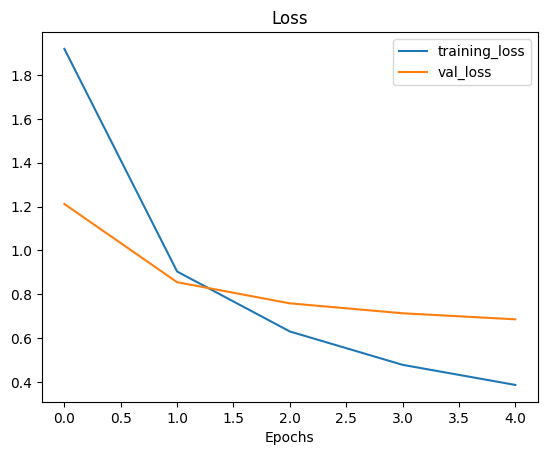

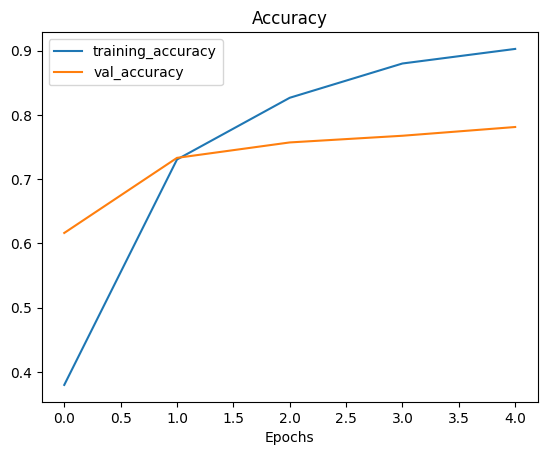

In [18]:

plot_loss_curves(resnet_history)

In [19]:

# Resnet summary
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [20]:

# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])


Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20230818-023228
Epoch 1/5
24/24 [==============================] - 23s 531ms/step - loss: 1.8108 - accuracy: 0.4547 - val_loss: 1.2749 - val_accuracy: 0.7304
Epoch 2/5
24/24 [==============================] - 10s 447ms/step - loss: 1.0390 - accuracy: 0.7760 - val_loss: 0.8658 - val_accuracy: 0.8208
Epoch 3/5
24/24 [==============================] - 10s 443ms/step - loss: 0.7493 - accuracy: 0.8307 - val_loss: 0.6967 - val_accuracy: 0.8476
Epoch 4/5
24/24 [==============================] - 10s 414ms/step - loss: 0.6065 - accuracy: 0.8587 - val_loss: 0.6075 - val_accuracy: 0.8612
Epoch 5/5
24/24 [==============================] - 12s 505ms/step - loss: 0.5142 - accuracy: 0.8867 - val_loss: 0.5576 - val_accuracy: 0.8628


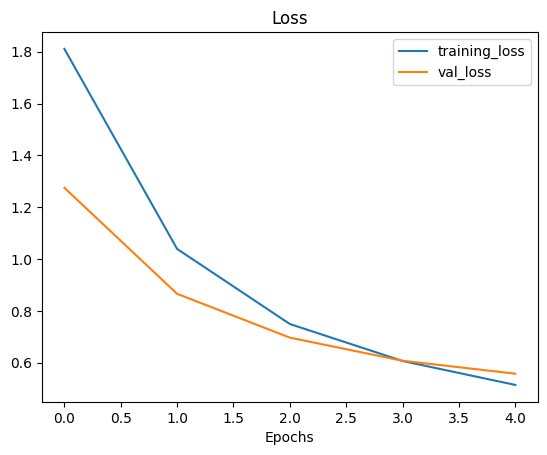

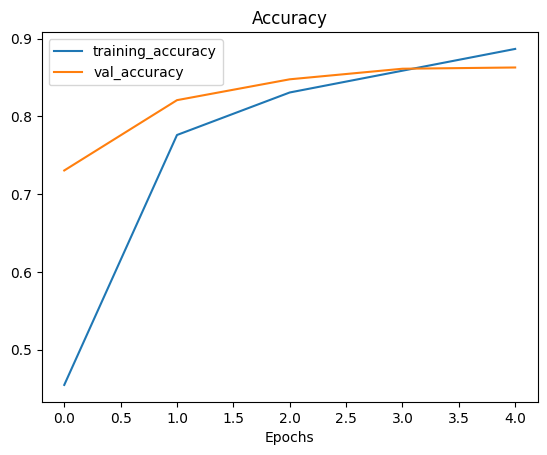

In [21]:
plot_loss_curves(efficientnet_history)

In [22]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

2023-08-18 02:45:57.037065: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   QFQ-SKH-WTF

QFQ-SKH-WTF
kidiste.gizachew@gmail.com


New experiment created. View your Ten

In [23]:
# Check out experiments
!tensorboard dev list

2023-08-18 02:52:13.181781: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/XK2c5b7KT0Cn2ToxS8nJ9w/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training images
	Id                   XK2c5b7KT0Cn2ToxS8nJ9w
	Created              2023-08-18 02:47:41 (4 minutes ago)
	Updated              2023-08-18 02:47:46 (4 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5811173
Total: 1 experiment(s)


In [24]:
# Delete an experiment
!tensorboard dev delete --experiment_id XK2c5b7KT0Cn2ToxS8nJ9w

2023-08-18 02:53:25.378339: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Deleted experiment XK2c5b7KT0Cn2ToxS8nJ9w.


In [25]:
# Check to see if experiments still exist
!tensorboard dev list

2023-08-18 02:53:55.871579: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No experiments. Use `tensorboard dev upload` to get started.
